<a href="https://colab.research.google.com/github/Axle-Bucamp/Text-analysis-for-RH/blob/main/Text_analysis_Proximity_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dépendances

In [53]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install -q transformers

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 27.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.4 MB/s 
     |████████████████████████████████| 163 kB 58.4 MB/s 


In [2]:
import numpy as np
import pandas as pd
import nltk
from string import punctuation
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import networkx as nx
from IPython.display import Image
from transformers import pipeline
import matplotlib.pyplot as plt

nltk.download('popular')
nltk.corpus.gutenberg.fileids()

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

# Jeux de données

Ici des textes venant du projet Gutenberg sont utilisé afin de démontrer l'utilité du projet. Ils s'agit de Text populaire dont on peut accéder aux corpus publiquement en utilisant la méthode montrer plus bas.

In [3]:
arr = []
i = 0
for fileid in nltk.corpus.gutenberg.fileids():
     num_chars = len(nltk.corpus.gutenberg.raw(fileid))
     num_words = len(nltk.corpus.gutenberg.words(fileid))
     num_sents = len(nltk.corpus.gutenberg.sents(fileid))
     num_vocab = len(set(w.lower() for w in nltk.corpus.gutenberg.words(fileid)))
     arr.append([fileid, round(num_chars/num_words), round(num_words/num_sents), round(num_words/num_vocab)])

arr = np.array(arr)
df = pd.DataFrame(arr, columns=["fileid","char/word", "word/sent", "word/vocab"])
df.head()

,fileid,char/word,word/sent,word/vocab
0,austen-emma.txt,5,25,26
1,austen-persuasion.txt,5,26,17
2,austen-sense.txt,5,28,22
3,bible-kjv.txt,4,34,79
4,blake-poems.txt,5,19,5


# Proximity Graph

Ce graphique est un moyen de mettre en relation diffèrents text selon leur utilisation des mots. Ici une LDA va pour chaque texte analyser la manière dont les mots sont utilisé et ensuite le comparer aux autres text. De nombreux modèles sont utiliser alors celà prend du temps sur de large text, pour limiter le calcul on utilise ici que les 1000 premier mots.

In [8]:
newsgroups = fetch_20newsgroups()
eng_stopwords = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\s+', gaps=True)
stemmer = PorterStemmer()
translate_tab = {ord(p): u" " for p in punctuation}

def text2tokens(raw_text):
    """Split the raw_text string into a list of stemmed tokens."""
    clean_text = raw_text.lower().translate(translate_tab)
    tokens = [token.strip() for token in tokenizer.tokenize(clean_text)]
    tokens = [token for token in tokens if token not in eng_stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return [token for token in stemmed_tokens if len(token) > 2]  # skip short tokens

le = len(nltk.corpus.gutenberg.fileids())
arr = np.zeros((le,le))
list_id = nltk.corpus.gutenberg.fileids().copy()

for fileid in nltk.corpus.gutenberg.fileids():
  data = [text2tokens(txt) for txt in nltk.corpus.gutenberg.words(fileid)[:1000]]
  list_id.remove(fileid)

  for compared_id in list_id:
    if compared_id != fileid:
      compare_data =  [text2tokens(txt) for txt in nltk.corpus.gutenberg.words(compared_id)[:1000]] 
      dataset = data + compare_data
      dictionary = Dictionary(documents=dataset, prune_at=None)
      dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n=None)  # use Dictionary to remove un-relevant tokens
      dictionary.compactify()

      d2b_dataset = [dictionary.doc2bow(doc) for doc in data]
      lda_x = LdaMulticore(
          corpus=d2b_dataset, num_topics=15, id2word=dictionary,
          workers=4, eval_every=None, passes=10, batch=True,
      )

      d2b_dataset = [dictionary.doc2bow(doc) for doc in compare_data]
      lda_y = LdaMulticore(
          corpus=d2b_dataset, num_topics=15, id2word=dictionary,
          workers=4, eval_every=None, passes=10, batch=True,
      )

      index_x = nltk.corpus.gutenberg.fileids().index(compared_id)
      index_y = nltk.corpus.gutenberg.fileids().index(fileid)
      arr[index_x, index_y] = np.mean(lda_x.diff(lda_y)[0])
      arr[index_y, index_x] = np.mean(lda_x.diff(lda_y)[0])

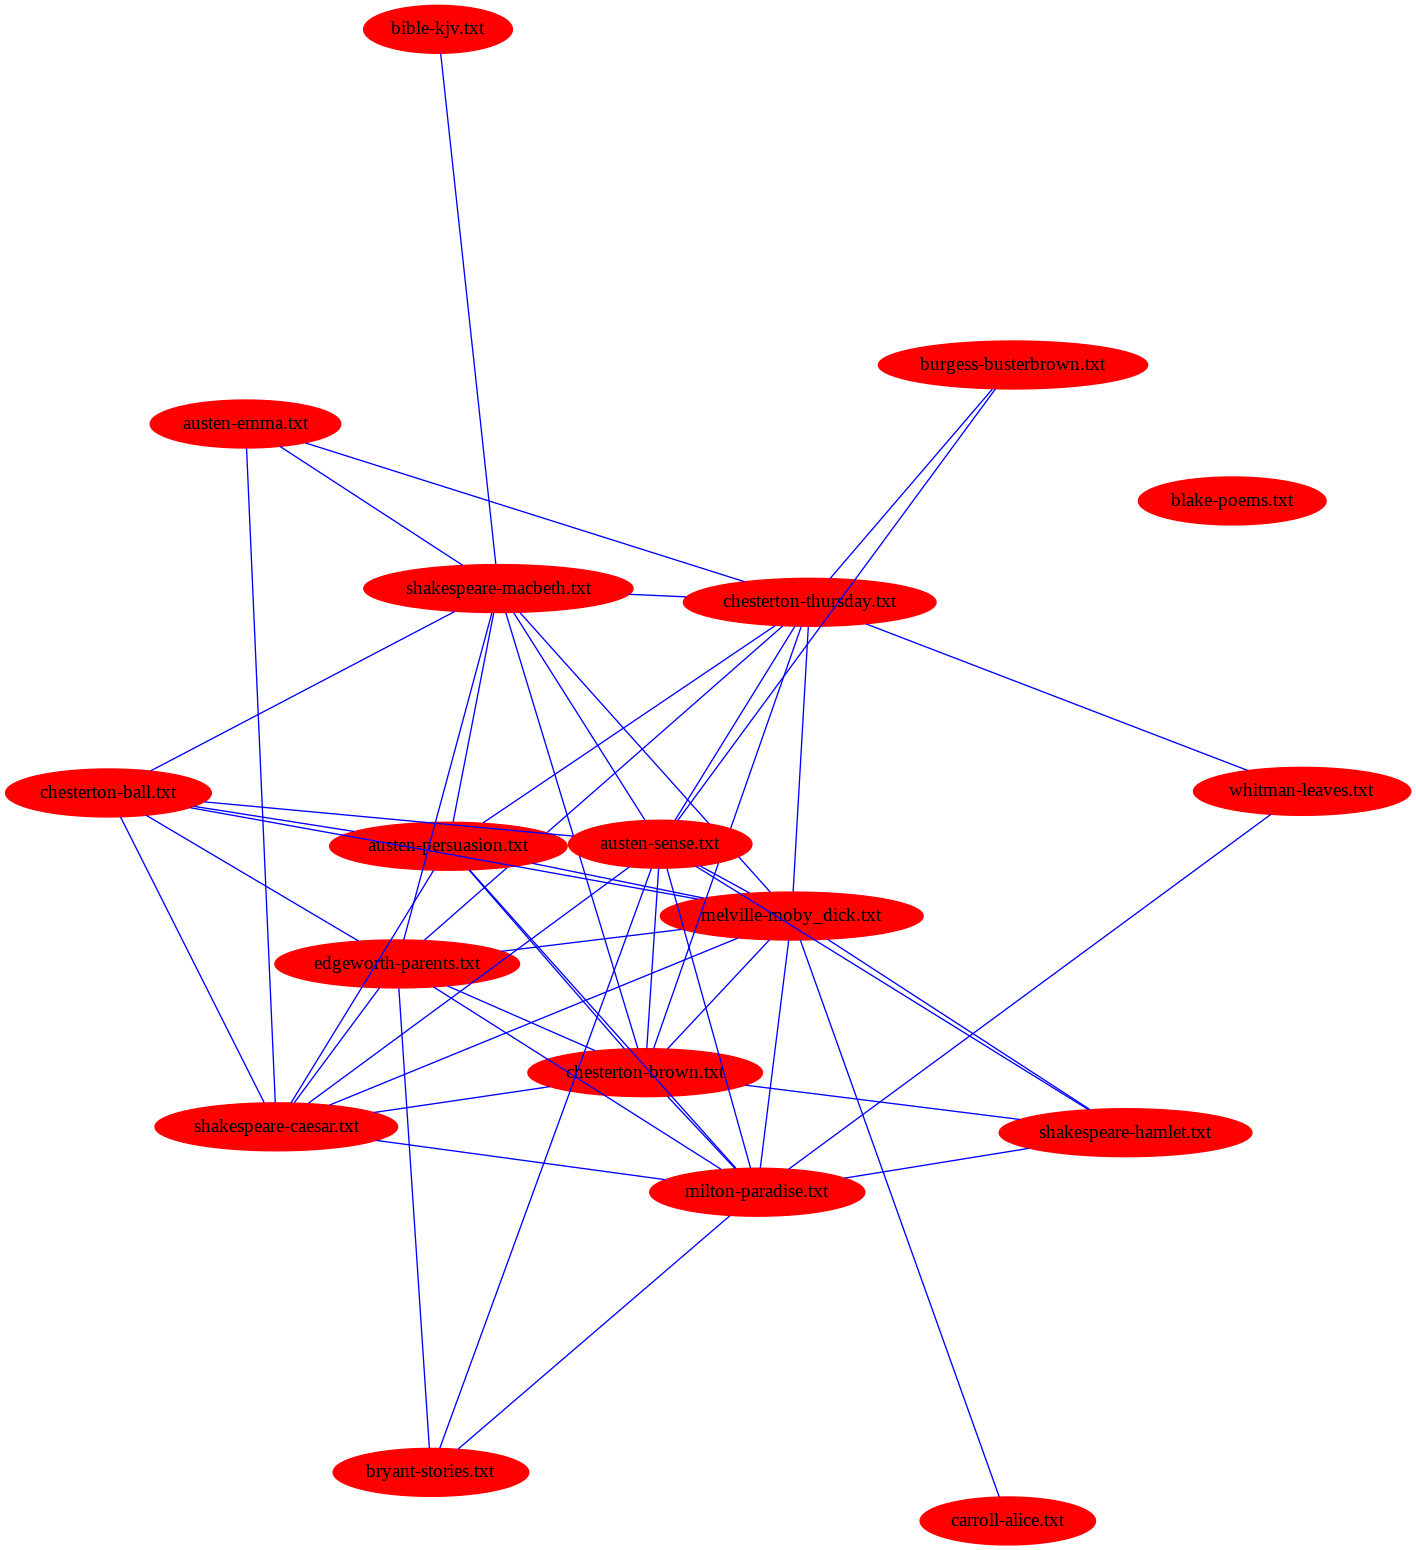

In [9]:
# graph from dist matrix
dt = [('len', float)]
arz = arr.copy()
arz[arz > np.mean(arz)] = 0
arz = arz * 10
A = arz.view(dt)
G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), nltk.corpus.gutenberg.fileids())))    

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="blue", width="2")
G.draw('out.png', format='png', prog='neato')

Image(filename='out.png')

In [10]:
np.mean(arr)

0.4957368218810447

# top word Fréquency

Ici un calcul plus courant est utilisé, celui ci ne sélectionnant que les mots les plus importants et compte leur fréquences que nous affichont ensuite. 

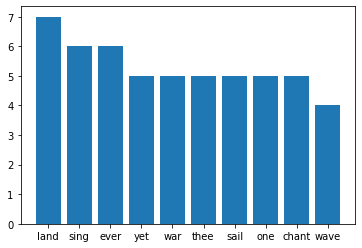

In [50]:
data = [text2tokens(txt) for txt in nltk.corpus.gutenberg.words(fileid)[:1000]]

data = list(filter(None, data))
data = np.array(data)
unique, counts = np.unique(data, return_counts=True)

zipped_lists = zip(counts, unique)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)
counts, unique = [ list(tuple) for tuple in tuples]

plt.bar(unique[0:10], counts[0:10])
plt.show()

# Sentiment analysis

Afin de compléter nous pouvons analyser les sentiments mit en avant dans chaque text.

In [66]:
# sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")
sentiment_pipeline(nltk.corpus.gutenberg.raw(fileid)[:1000])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.6515674591064453}]

# recommandation system

le but de cette dernière section sera de sélectionner de diverses manière un nombre d'observation donnés correspondant aux plus haut score selon une méthode de ranking choisit par l'utilisateur. 